Book ratings from
http://www2.informatik.uni-freiburg.de/~cziegler/BX/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12.5,5)

In [3]:
data_dir = r'C:\Users\Trost\Desktop\Words\BX-CSV-Dump\BX-Book-Ratings.csv'

In [6]:
data = pd.read_csv(data_dir,header=0,sep=";",encoding = "ISO-8859-1")

In [7]:
data.head()

,User_ID,ISBN,Book_Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
len(data)



1149780

# Find the ten users clisest to user 170155 using euclidean distance

Write a simple distance function that can use dataframesand numpy arrays

In [9]:
def naive_distance(X,Y,exponent):
    """computes the euclidean distance between two vectors of the same lengths"""
    if Y.shape != X.shape:
        return "not the same size"
    else:
        return (abs(X - Y)**exponent)**(1/exponent)

In [11]:
X = np.random.random(10)
Y = np.random.random(10)


X



array([ 0.98560076,  0.241837  ,  0.8025305 ,  0.69154919,  0.14825799,
        0.25739451,  0.31361567,  0.4732563 ,  0.89785971,  0.17166586])

In [12]:
naive_distance(X,Y,2)



array([ 0.25858597,  0.23122812,  0.01949566,  0.36315764,  0.35340748,
        0.06973094,  0.22585103,  0.32010436,  0.52228268,  0.04444098])

In [13]:
def Distance(Table1,Table2,exp):
    """computes p-norm between two tables Book_Rating
    exp specifies the minkoswsky norm (2 = euclidean distance,...).
    Tables are cleaned, i.e. only contains entries that were rated by our original user"""

    Table1 = Table1.set_index('ISBN') # sets index to ISBN, enabling us to align ratings of the same book
    Table2 = Table2.set_index('ISBN')      
    Table1['orig_user_rating'] = Table2.Book_Rating #align 
    #compute the distance (same as in naive)
    Table1['Distance'] = pd.DataFrame((((abs(Table1.Book_Rating - Table1.orig_user_rating))**exp)**(1/exp)))
    Table1.reset_index()
    return(Table1)


In [16]:
def nearest_user(data,user=170155,exp = 2):#=170155
    """takes a User ID and computes a DataFrame sorted by the distance to user"""
    
    mask = data.User_ID.isin([user]) #mask for userdata

    UserData = data[mask]# split in User Data and Data without the User
    WithoutUserData = data[-mask]
        
    SampleOfUsersThatReadSameBooks = WithoutUserData.ISBN.isin(UserData.ISBN)#clean data, we don't have to use all the data
    SameRead = WithoutUserData[SampleOfUsersThatReadSameBooks]#we do not need all the other entries.

    d = Distance(SameRead,UserData,exp) #call Distance function
    Mean = d.groupby('User_ID').mean() #group and get mean (instead of sum because of uneequal shared items)
    Nearest = Mean.sort_values('Distance')
    return(Nearest) #return sorted dataframe 
        


In [17]:
a = nearest_user(data)
%timeit nearest_user(data)
a[:10]


1 loops, best of 3: 215 ms per loop


,Book_Rating,orig_user_rating,Distance
User_ID,,,
278111,0,0,0
206944,0,0,0
102375,0,0,0
207056,0,0,0
100906,0,0,0
207494,7,7,0
207835,8,8,0
100459,0,0,0
99963,0,0,0


In [18]:
a[-5:]



,Book_Rating,orig_user_rating,Distance
User_ID,,,
202963,10,0,10
203441,10,0,10
203935,10,0,10
95300,10,0,10
567,10,0,10


# find the ten items with the highest adjusted cosine similarity

\begin{align*} sim(i, j) &= \frac{ \sum_{u \in U} (r_u^i - \bar{r}_u) (r_u^j - \bar{r}_u) } { \sqrt{ \sum_{u \in U} (r_u^i - \bar{r}_u)^2 } \sqrt{ \sum_{u \in U} (r_u^j - \bar{r}_u)^2 } } \end{align*}

with

$r_u^i$ being the rating of user and current item

$r_u^j$ same user, different item

$\bar{r}_u$ being the average rating that the user gave 


As we can see, having the mean of each user in a separate column might come in handy. 

In [19]:
def AddUserMean(Table):
    #another cool pandas feature. This adds a column aligned on a certain other one.
    Table = Table.join( Table.groupby('User_ID')['Book_Rating'].mean(), on='User_ID',rsuffix = '_User_mean')
    return(Table)


In [20]:
def CosSim(Table1, Table2):
    """computes Cosine Similarity"""

    Table1 = Table1.set_index('User_ID')#set index to User
    Table2 = Table2.set_index('User_ID')

    Table1['Item_Rating'] = Table2.Book_Rating# get rating of user of item, align on user_id
        
    Table1.reset_index() #resets the index to numerical (who'd have thought)
        
        
    #renaming some variables for better understanding
    rui = Table1.Item_Rating # rating of item-of-interest by user
    ruj = Table1.Book_Rating # rating of other item by user
    r_u = Table1.Book_Rating_User_mean # mean rating of the user

        
    # long distance function. You'll see that the sum happens later
    Table1['CosDis'] = (((rui-r_u)*(ruj-r_u))/np.sqrt(sum((rui-r_u))**2)*np.sqrt(sum((ruj-r_u))**2))
    
    del Table1['Book_Rating']#deleting unneccessary rows 
    del Table1['Book_Rating_User_mean']
    del Table1['Item_Rating']
    return(Table1)#return sorted array

In [25]:
def nearest_item(data, item = '0446520802' ):#0155061224#0446520802
        """takes in item Number and calls CosSim, which 
        computes the nearest items according to 
        Adjusted Cosine Similarity"""
        
        test = data.copy()#necessary because of next step
        #this has to be done here, otherwise the mean willl be biased (the item itself will not be in the mean)
        
        test = AddUserMean(test)# add the user mean
        
        mask = test.ISBN.isin([item]) #create bool array 
        Book_Ratings = test[mask] # the ratings our item received
        Others_Ratings = test[-mask] # the ratings of the others
        
        BooksThatWereReadBySameUser = Others_Ratings.User_ID.isin(Book_Ratings.User_ID) # only use users that have rated our item
        InterestingCases = Others_Ratings[BooksThatWereReadBySameUser]     #reduces number of cases from 1149780 to 54481  thats about 5% left.  

        Nearest = CosSim(InterestingCases,Book_Ratings)# call CosSim

        Nearest = Nearest.groupby('ISBN').sum() #groupby ISBN and sum we can do the sum here because the denominator is 
        #only dependend on the item ISBN
        Nearest = Nearest.sort('CosDis',ascending=False)#sort

        return(Nearest)


In [26]:
a = nearest_item(data)
%timeit nearest_item(data)
a[:6]


C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


1 loops, best of 3: 716 ms per loop


,CosDis
ISBN,
0316710571,0.131275
0451190572,0.116380
0452279178,0.113003
038533558X,0.103347
0553296981,0.091346
0439064864,0.087345


# recommend 6 items to user

In [27]:




def get_rec_user(data,user_based_rec):
    similar_users = list(user_based_rec[:6].index) # get list of 6 most similar users
    mask = data.User_ID.isin(similar_users) #create bool array for similar users
    similar_user_favs = data[mask] # only use similar users

    test = similar_user_favs.groupby('ISBN').mean() #groups the list by ISBNs. 
    test = test.sort('Book_Rating',ascending=False)# return df sorted by book rating
    #    print(test)
    return(test)


In [28]:
def new_user(data,user=219459, book= '0446520802'):#'0446520802'):#'0155061224',,,552147729
    
    user_based_rec = nearest_user(data,user,2)# nearest users
    item_based_rec = nearest_item(data,book) # nearest items
    highest_rated = data.groupby('ISBN').mean()# highest rated books
    
    if user_based_rec.empty and item_based_rec.empty:

        return highest_rated[:6]#if no additional info: recommend "best" books to new user
    elif user_based_rec.empty and not item_based_rec.empty:

        return item_based_rec[:6] # return item based rec
    elif item_based_rec.empty and not user_based_rec.empty:
        user_based = get_rec_user(data,user_based_rec)
        return user_based[:6]# return user based rec
    else:
        user_based = get_rec_user(data,user_based_rec)
        return pd.concat([user_based[:3],item_based_rec[:3]]) # return half-half

In [29]:
a = new_user(data)
%timeit new_user(data)
a


C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


1 loops, best of 3: 2.12 s per loop


,Book_Rating,CosDis,User_ID
ISBN,,,
0099628716,10,NaN,160541
0747256152,10,NaN,157247
3404139178,10,NaN,132500
0316666343,NaN,3.074204e-317,NaN
0860074382,NaN,2.944812e-317,NaN
0877017883,NaN,2.800768e-317,NaN


In [30]:




b = new_user(data,user=170155,book=29)
%timeit new_user(data,user=170155,book=29)
b


C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


1 loops, best of 3: 1.94 s per loop


,User_ID,Book_Rating
ISBN,,
0684801523,206944,10
0685340651,100906,10
0140286764,100906,10
088001301X,100906,10
0425126064,207494,10
0312862113,207494,10


# Randomly delete 20% of the ratings and try to predict them.

In [31]:
from random import sample

def del_20(data):
        minus20 = data.copy() # don't delete it in original 
        mask =  np.array(sample(range(len(minus20)),round(len(minus20)*.2))) #create 20% NaNs
        minus20['orig_vals'] = minus20.Book_Rating # store original values
        minus20['Book_Rating'].ix[mask] = np.nan # delete specified values
        return(minus20)


In [32]:



without_20 = del_20(data)
without_20.Book_Rating.isnull().any() #check if there are any nans in Book_rting


C:\Users\Trost\Anaconda3\lib\site-packages\pandas\core\indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


True

In [35]:
without_20[:10]



,User_ID,ISBN,Book_Rating,orig_vals
0,276725,034545104X,0,0
1,276726,0155061224,5,5
2,276727,0446520802,0,0
3,276729,052165615X,3,3
4,276729,0521795028,6,6
5,276733,2080674722,NaN,0
6,276736,3257224281,NaN,8
7,276737,0600570967,NaN,6
8,276744,038550120X,7,7
9,276745,342310538,NaN,10


## fill in values that belong to a book that has been rated exactly once.

This is kinda problematic, because books that have been rated only once/a few times (if that value gets deleted) don't have any backup information we could use. Therefore we just predict the mean. Not perfect, but it's something.


In [84]:
def fill_single_rated_nan(data):
    #find books that are rated exactly once and set rating to mean rating
    data['ones'] = 1 # add counter 
    data = data.join(data.groupby('ISBN')['ones'].count(), on='ISBN',rsuffix = '_count') # .count() counter
    
    mask_rated_once = data.ones_count == 1 # create mask where counted counter is still 1
    mask_is_na = data.Book_Rating.isnull() # create mask for missing entries
    mask_both = (mask_rated_once & mask_is_na) # create combined mask where both other masks are true
    data['mask_rated_once'] = mask_rated_once
    data['mask_is_na'] = mask_is_na
    data['mask'] = mask_both
    data['Book_Rating_new'] = data.Book_Rating # set new book rating to a copy of the one containing the deleted entries
    data['Book_Rating_new'][mask_both] = data.Book_Rating.mean() #fill in the mean in places where the mask is true
    del data['User_ID']
    del data['ones']
    #del data['ones_count']
    del data['mask_rated_once']
    #del data['mask_is_na']
    return(data)


In [85]:
a = fill_single_rated_nan(without_20)

C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## fill values for books that have additional information

Other books have been rated several times, i.e. they have backup information. We will use the mean rating a book received to fill up the gaps.


In [86]:
def add_book_mean(data):
    """get the book mean"""
    Table = data.join( data.groupby('ISBN')['Book_Rating'].mean(), on='ISBN',rsuffix = '_Mean') # ignores NaNs by default. Like R.
    return(Table)


In [87]:
c = data.copy()
d = add_book_mean(c)
d.head()

,User_ID,ISBN,Book_Rating,Book_Rating_Mean
0,276725,034545104X,0,2.933333
1,276726,0155061224,5,2.500000
2,276727,0446520802,0,4.060345
3,276729,052165615X,3,3.000000
4,276729,0521795028,6,6.000000


In [88]:
def fill_informative_nan(data):
    """fills "informative" entries with the mean rating of the book"""
    
    data_with_mean = add_book_mean(data) #add book mean
    mask = data_with_mean.Book_Rating_new.isnull()# create that indicates if entries are missing
    data['B_R_New'] = data_with_mean.Book_Rating_new # set to intermediate-filled 
    data['B_R_New'][mask] = data_with_mean['Book_Rating_Mean'] #fills with the book mean
    return data

In [89]:
x = fill_informative_nan(a)
x[:10]

C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ISBN,Book_Rating,orig_vals,ones_count,mask_is_na,mask,Book_Rating_new,B_R_New
0,034545104X,NaN,0,60,True,False,NaN,2.727273
1,0155061224,NaN,5,2,True,False,NaN,0.000000
2,0446520802,NaN,0,116,True,False,NaN,4.076087
3,052165615X,3,3,1,False,False,3.000000,3.000000
4,0521795028,6,6,1,False,False,6.000000,6.000000
5,2080674722,0,0,3,False,False,0.000000,0.000000
6,3257224281,8,8,5,False,False,8.000000,8.000000
7,0600570967,NaN,6,1,True,True,2.866344,2.866344
8,038550120X,7,7,184,False,False,7.000000,7.000000
9,342310538,10,10,2,False,False,10.000000,10.000000


In [90]:




filled_single = fill_single_rated_nan(without_20)
#filled_single_mean = add_book_mean(filled_single)
filled_all = fill_informative_nan(filled_single)
filled_all.B_R_New.isnull().any()


C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


True

## still NaNs?

There are (a few) books, that still contain nans. The guess is that those are books that had several ratings that all got deleted in the process


In [91]:
testtest = filled_all[filled_all.B_R_New.isnull()] #how many entries are there?
len(testtest)

5497

In [92]:
max(testtest.ones_count) #whats the maximum of ratings one of thos books had?



5

In [93]:
np.mean(testtest.ones_count) #what is the mean number of ratings that books had?

2.1569947243951244

In [94]:
filled_all['B_R_New'][filled_all.B_R_New.isnull()] = filled_all.B_R_New.mean() # fill them up with mean, since we're pretty 
#sure that we're dealing with "unfortunately deleted" entries
filled_all.B_R_New.isnull().any()

C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


False

In [95]:
filled_all.B_R_New.mean()



2.857660943076448

In [96]:
filled_all.orig_vals.mean()



2.8669501991685364

In [97]:
def avg_error(Table):
    """computes our average error"""
    return (sum((Table.orig_vals[filled_all.mask_is_na] 
                 - Table.B_R_New[Table.mask_is_na])**2)**1/2
           )/len(Table.mask_is_na)

In [98]:
avg_error(filled_all)



1.6747564384266398

In [99]:




estimate = list()

for i in range(100):
    #call some functions from before
    
    without_20 = del_20(data)
    filled_single = fill_single_rated_nan(without_20)
    filled_all = fill_informative_nan(filled_single)
    filled_all['B_R_New'][filled_all.B_R_New.isnull()] = filled_all.B_R_New.mean()
    
    estimate.append(avg_error(filled_all))
    
    
np.mean(estimate)


C:\Users\Trost\Anaconda3\lib\site-packages\pandas\core\indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.5563662359960369

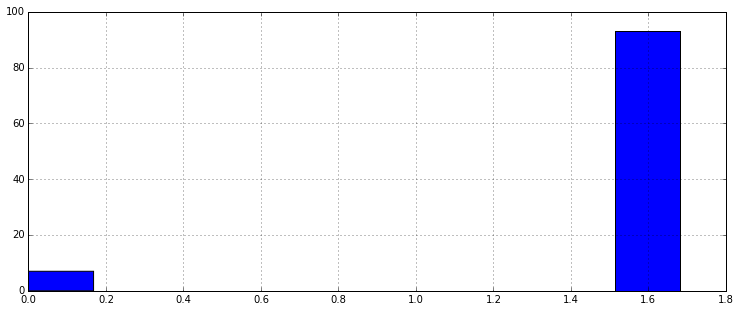

In [100]:
plotting = pd.Series(estimate)
plotting.hist()